# seq2seq Train and Greedy search

# 0. GPU测试

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")
import sys
#sys.path.append('/mnt/pycharm_class04')
sys.path.append('/Users/ianxiao/Code/DeepLearning/class04')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from utils.data_loader import build_dataset,load_dataset,preprocess_sentence,load_test_dataset,load_train_dataset
from utils.wv_loader import load_embedding_matrix, Vocab
from utils.config import *
from gensim.models.word2vec import LineSentence, Word2Vec
from utils.gpu_utils import config_gpu
import tensorflow as tf
from utils.plot_utils import plot_attention
from tqdm import tqdm
import time
from seq2seq_tf2.batcher import train_batch_generator

In [4]:
config_gpu()

# 0. 预处理数据

In [5]:
%%time
# build_dataset(train_data_path,test_data_path)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


# 1. 加载数据

## 1.1  加载vocab

In [6]:
vocab = Vocab(vocab_file=vocab_path)

In [7]:
vocab.START_DECODING, vocab.START_DECODING_INDEX

('<START>', 2)

In [8]:
vocab.count

31819

## 1.2 基本参数设置

In [9]:
params = {}
params["vocab_size"] = vocab.count
params["embedding_dim"] = 300
params["enc_units"] = 512
params["attn_units"] = 512
params["dec_units"] = 512
params["batch_size"] = 32
params["epochs"] = 5
params["max_enc_len"] = 200
params["max_dec_len"] = 41

## 1.3 加载数据集 

In [10]:
dataset, steps_per_epoch = train_batch_generator(batch_size=params["batch_size"] ,
                                                 max_enc_len=params["max_enc_len"],
                                                 max_dec_len=params["max_dec_len"])
test_X = load_test_dataset(params["max_enc_len"])
train_X, train_Y = load_train_dataset(params['max_enc_len'], params['max_dec_len'])

In [11]:
len(train_X), len(train_Y), len(test_X)

(82873, 82873, 20000)

In [12]:
steps_per_epoch

2589

In [13]:
82873 // params['batch_size']

2589

In [14]:
dataset

<BatchDataset shapes: ((32, 200), (32, 40)), types: (tf.int64, tf.int64)>

## 1.4 加载预训练权重

In [15]:
embedding_matrix=load_embedding_matrix(embedding_matrix_path)

In [16]:
embedding_matrix.shape

(31819, 300)

# 2. 构建模型

In [17]:
from seq2seq_tf2.seq2seq_model import Seq2Seq

In [18]:
model=Seq2Seq(params)

# 3. 读取训练好的模型

In [19]:
from utils.config import seq2seq_checkpoint_dir,seq2seq_checkpoint_prefix

In [19]:
ckpt = tf.train.Checkpoint(Seq2Seq=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, seq2seq_checkpoint_prefix, max_to_keep=5)

In [20]:
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

Model restored


# 4. 训练

In [22]:
optimizer = tf.keras.optimizers.Adam(name='Adam',learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(real, pred):
    pad_mask = tf.math.equal(real, vocab.PAD_TOKEN_INDEX)
    unk_mask = tf.math.equal(real, vocab.UNKNOWN_TOKEN_INDEX)
    mask = tf.math.logical_not(tf.math.logical_or(pad_mask,unk_mask))
    
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [23]:
#@tf.function
def train_step(inp, targ):
    loss = 0
    
    with tf.GradientTape() as tape:
        # 1. 构建encoder
        enc_output, enc_hidden = model.call_encoder(inp)
        # 2. 复制
        dec_hidden = enc_hidden
        # 3. <START> * BATCH_SIZE 
        dec_input = tf.expand_dims([vocab.START_DECODING_INDEX] * params["batch_size"], 1)
        
        # 逐个预测序列
        predictions, _ = model(dec_input, dec_hidden, enc_output, targ)
        
        batch_loss = loss_function(targ[:, 1:], predictions)

        variables = model.encoder.trainable_variables + model.decoder.trainable_variables+ model.attention.trainable_variables
    
        gradients = tape.gradient(batch_loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [24]:
epochs = params["epochs"]
# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    
for epoch in tqdm(range(epochs)):
    start = time.time()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

        if batch % 1 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 4.5357
Epoch 1 Batch 1 Loss 4.0905
Epoch 1 Batch 2 Loss 4.0176
Epoch 1 Batch 3 Loss 4.6302
Epoch 1 Batch 4 Loss 3.5611
Epoch 1 Batch 5 Loss 4.3306
Epoch 1 Batch 6 Loss 4.1487
Epoch 1 Batch 7 Loss 3.6022
Epoch 1 Batch 8 Loss 3.9256
Epoch 1 Batch 9 Loss 3.0930
Epoch 1 Batch 10 Loss 3.1431
Epoch 1 Batch 11 Loss 3.2329
Epoch 1 Batch 12 Loss 2.9203
Epoch 1 Batch 13 Loss 2.4651
Epoch 1 Batch 14 Loss 2.4738
Epoch 1 Batch 15 Loss 3.4383
Epoch 1 Batch 16 Loss 2.7624
Epoch 1 Batch 17 Loss 3.5343
Epoch 1 Batch 18 Loss 2.9936
Epoch 1 Batch 19 Loss 2.7242
Epoch 1 Batch 20 Loss 3.2700
Epoch 1 Batch 21 Loss 3.2139
Epoch 1 Batch 22 Loss 3.1080
Epoch 1 Batch 23 Loss 3.0818
Epoch 1 Batch 24 Loss 2.9912
Epoch 1 Batch 25 Loss 3.1859
Epoch 1 Batch 26 Loss 3.4706
Epoch 1 Batch 27 Loss 2.9746
Epoch 1 Batch 28 Loss 2.3567
Epoch 1 Batch 29 Loss 2.7548
Epoch 1 Batch 30 Loss 2.8786
Epoch 1 Batch 31 Loss 2.9916
Epoch 1 Batch 32 Loss 2.6941
Epoch 1 Batch 33 Loss 2.7119
Epoch 1 Batch 34 Loss 3.

 20%|██        | 1/5 [31:43<2:06:55, 1903.86s/it]

Epoch 1 Batch 2588 Loss 1.6616
Epoch 1 Loss 2.0747
Time taken for 1 epoch 1903.8640513420105 sec

Epoch 2 Batch 0 Loss 1.4060
Epoch 2 Batch 1 Loss 1.5046
Epoch 2 Batch 2 Loss 1.7824
Epoch 2 Batch 3 Loss 1.6180
Epoch 2 Batch 4 Loss 1.3900
Epoch 2 Batch 5 Loss 1.5274
Epoch 2 Batch 6 Loss 1.4689
Epoch 2 Batch 7 Loss 1.6016
Epoch 2 Batch 8 Loss 1.7601
Epoch 2 Batch 9 Loss 1.5479
Epoch 2 Batch 10 Loss 1.5457
Epoch 2 Batch 11 Loss 1.4731
Epoch 2 Batch 12 Loss 1.5464
Epoch 2 Batch 13 Loss 1.5668
Epoch 2 Batch 14 Loss 1.2727
Epoch 2 Batch 15 Loss 1.9397
Epoch 2 Batch 16 Loss 1.5340
Epoch 2 Batch 17 Loss 1.8146
Epoch 2 Batch 18 Loss 1.5237
Epoch 2 Batch 19 Loss 1.4616
Epoch 2 Batch 20 Loss 1.4876
Epoch 2 Batch 21 Loss 1.8566
Epoch 2 Batch 22 Loss 1.4997
Epoch 2 Batch 23 Loss 1.4830
Epoch 2 Batch 24 Loss 1.6625
Epoch 2 Batch 25 Loss 1.7048
Epoch 2 Batch 26 Loss 1.6521
Epoch 2 Batch 27 Loss 1.4231
Epoch 2 Batch 28 Loss 1.5939
Epoch 2 Batch 29 Loss 1.5836
Epoch 2 Batch 30 Loss 1.5453
Epoch 2 Batch

 40%|████      | 2/5 [1:04:18<1:35:57, 1919.04s/it]

Saving checkpoint for epoch 2 at /mnt/pycharm_class04/data/checkpoints/training_checkpoints_seq2seq/ckpt/ckpt-1
Epoch 2 Loss 1.5155
Time taken for 1 epoch 1954.4530375003815 sec

Epoch 3 Batch 0 Loss 1.2169
Epoch 3 Batch 1 Loss 1.0667
Epoch 3 Batch 2 Loss 1.2031
Epoch 3 Batch 3 Loss 1.3107
Epoch 3 Batch 4 Loss 1.5746
Epoch 3 Batch 5 Loss 1.5899
Epoch 3 Batch 6 Loss 1.1630
Epoch 3 Batch 7 Loss 1.1998
Epoch 3 Batch 8 Loss 1.3554
Epoch 3 Batch 9 Loss 1.2274
Epoch 3 Batch 10 Loss 1.3043
Epoch 3 Batch 11 Loss 1.3836
Epoch 3 Batch 12 Loss 1.4799
Epoch 3 Batch 13 Loss 1.6130
Epoch 3 Batch 14 Loss 1.3504
Epoch 3 Batch 15 Loss 1.3933
Epoch 3 Batch 16 Loss 1.2044
Epoch 3 Batch 17 Loss 1.4773
Epoch 3 Batch 18 Loss 1.1132
Epoch 3 Batch 19 Loss 1.3533
Epoch 3 Batch 20 Loss 1.3622
Epoch 3 Batch 21 Loss 1.0566
Epoch 3 Batch 22 Loss 1.4304
Epoch 3 Batch 23 Loss 1.4004
Epoch 3 Batch 24 Loss 1.4267
Epoch 3 Batch 25 Loss 1.1999
Epoch 3 Batch 26 Loss 1.3855
Epoch 3 Batch 27 Loss 1.4620
Epoch 3 Batch 28 Lo

 60%|██████    | 3/5 [1:36:39<1:04:11, 1925.59s/it]

Epoch 3 Batch 2588 Loss 1.5767
Epoch 3 Loss 1.3355
Time taken for 1 epoch 1940.880223274231 sec

Epoch 4 Batch 0 Loss 1.0888
Epoch 4 Batch 1 Loss 1.2566
Epoch 4 Batch 2 Loss 1.1330
Epoch 4 Batch 3 Loss 1.0478
Epoch 4 Batch 4 Loss 1.0408
Epoch 4 Batch 5 Loss 1.1647
Epoch 4 Batch 6 Loss 1.0679
Epoch 4 Batch 7 Loss 1.3774
Epoch 4 Batch 8 Loss 1.4561
Epoch 4 Batch 9 Loss 1.2125
Epoch 4 Batch 10 Loss 1.2542
Epoch 4 Batch 11 Loss 1.1805
Epoch 4 Batch 12 Loss 1.2381
Epoch 4 Batch 13 Loss 1.1656
Epoch 4 Batch 14 Loss 1.2581
Epoch 4 Batch 15 Loss 1.0329
Epoch 4 Batch 16 Loss 1.4202
Epoch 4 Batch 17 Loss 1.1183
Epoch 4 Batch 18 Loss 1.4189
Epoch 4 Batch 19 Loss 1.1495
Epoch 4 Batch 20 Loss 1.4130
Epoch 4 Batch 21 Loss 1.3404
Epoch 4 Batch 22 Loss 1.3915
Epoch 4 Batch 23 Loss 1.3354
Epoch 4 Batch 24 Loss 1.5257
Epoch 4 Batch 25 Loss 1.2257
Epoch 4 Batch 26 Loss 1.0224
Epoch 4 Batch 27 Loss 1.1834
Epoch 4 Batch 28 Loss 1.1778
Epoch 4 Batch 29 Loss 0.9617
Epoch 4 Batch 30 Loss 1.1500
Epoch 4 Batch 

 80%|████████  | 4/5 [2:08:46<32:06, 1926.12s/it]  

Saving checkpoint for epoch 4 at /mnt/pycharm_class04/data/checkpoints/training_checkpoints_seq2seq/ckpt/ckpt-2
Epoch 4 Loss 1.2221
Time taken for 1 epoch 1927.3391466140747 sec

Epoch 5 Batch 0 Loss 0.8580
Epoch 5 Batch 1 Loss 1.3293
Epoch 5 Batch 2 Loss 1.4148
Epoch 5 Batch 3 Loss 1.0564
Epoch 5 Batch 4 Loss 0.9249
Epoch 5 Batch 5 Loss 1.2833
Epoch 5 Batch 6 Loss 1.4440
Epoch 5 Batch 7 Loss 1.3153
Epoch 5 Batch 8 Loss 1.2021
Epoch 5 Batch 9 Loss 1.2706
Epoch 5 Batch 10 Loss 1.2313
Epoch 5 Batch 11 Loss 1.3164
Epoch 5 Batch 12 Loss 1.0845
Epoch 5 Batch 13 Loss 1.1815
Epoch 5 Batch 14 Loss 0.9677
Epoch 5 Batch 15 Loss 0.9933
Epoch 5 Batch 16 Loss 0.9846
Epoch 5 Batch 17 Loss 1.0539
Epoch 5 Batch 18 Loss 1.2779
Epoch 5 Batch 19 Loss 1.3919
Epoch 5 Batch 20 Loss 0.7661
Epoch 5 Batch 21 Loss 1.2117
Epoch 5 Batch 22 Loss 1.2456
Epoch 5 Batch 23 Loss 1.1634
Epoch 5 Batch 24 Loss 1.1582
Epoch 5 Batch 25 Loss 1.1728
Epoch 5 Batch 26 Loss 1.1643
Epoch 5 Batch 27 Loss 1.2196
Epoch 5 Batch 28 Lo

100%|██████████| 5/5 [2:40:48<00:00, 1929.68s/it]

Epoch 5 Batch 2588 Loss 1.2091
Epoch 5 Loss 1.1372
Time taken for 1 epoch 1921.8741664886475 sec



In [25]:
ckpt_save_path = ckpt_manager.save()

In [26]:
ckpt_save_path

'/mnt/pycharm_class04/data/checkpoints/training_checkpoints_seq2seq/ckpt/ckpt-3'

Time taken for 1 epoch 524.4936063289642 sec

Epoch 5 Loss 1.1372

Time taken for 1 epoch 1921.8741664886475 sec

#  Restore the latest checkpoint and test

In [20]:
ckpt = tf.train.Checkpoint(Seq2Seq=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, seq2seq_checkpoint_prefix, max_to_keep=5)
# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [21]:
seq2seq_checkpoint_prefix

'/Users/ianxiao/Code/DeepLearning/class04/data/checkpoints/training_checkpoints_seq2seq/ckpt'

In [22]:
print(ckpt_manager.latest_checkpoint)

/Users/ianxiao/Code/DeepLearning/class04/data/checkpoints/training_checkpoints_seq2seq/ckpt/ckpt-3


# 预测

In [23]:
def evaluate(model,inputs, vocab, params):
    attention_plot = np.zeros((params['max_dec_len'], params['max_enc_len']))

    inputs = tf.convert_to_tensor(inputs)

    result = ''
    
    enc_hidden = tf.zeros((1, params["enc_units"]))
    
    enc_output, enc_hidden = model.encoder(inputs, enc_hidden)

    dec_hidden = enc_hidden
    
    dec_input = tf.expand_dims([vocab.START_DECODING_INDEX], 0)
    
    context_vector, _ = model.attention(dec_hidden, enc_output)

    for t in range(params['max_dec_len']):
        
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        
        predictions, dec_hidden = model.decoder(dec_input,
                                         dec_hidden,
                                         enc_output,
                                         context_vector)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += vocab.id2word[predicted_id] + ' '
        if vocab.id2word[predicted_id] == '<STOP>':
            return result, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

In [24]:
def generate_summary(sentence, vocab, params):
    
    sentence, sentence_ids = preprocess_sentence(sentence,params["max_enc_len"],vocab.word2id)
    
    result, attention_plot = evaluate(model,sentence_ids, vocab, params)
    
    if vocab.PAD_TOKEN in sentence:
        sentence = sentence[:sentence.index(vocab.PAD_TOKEN)]
    
    print('Input: %s' % (sentence))
    print('Predicted summary: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [25]:
sentence='技师说：右侧排气管上方，缸体上靠近变速箱|车主说：[图片]|车主说：是不是这个？|车主说：这个号不对|车主说：[图片]|技师说：你先拓下来跟行车证对下|车主说：对了，不是|车主说：你有没有图片？|技师说：那年的车|车主说：14年3.0牧马人|技师说：做前轮这边缸体上|车主说：有没有图片画个圈圈|车主说：要不要拆什么|车主说：？？|技师说：不要拆|车主说：都看了，看不到啊|技师说：[图片]|车主说：[图片]|车主说：这个发动机怎么和我的不一样|技师说：你是客户还是维修技师|技师说：柴油还是汽油版|车主说：汽油|车主说：我自己的车，过户要用|技师说：你要找维修人员，或者专门拓号的人'

Input: <START> 技师说 右侧 排气管 上方 ， 缸体 上 靠近 变速箱 车主说 车主说 是不是 ？ 车主说 号 不 车主说 技师说 先 <UNK> 行车证 对下 车主说 ， 不是 车主说 有没有 ？ 技师说 那年 车 车主说 14 年 3.0 牧马人 技师说 做 前轮 缸体 上 车主说 有没有 画个 圈圈 车主说 不要 拆 车主说 ？ ？ 技师说 不要 拆 车主说 都 看 ， 看不到 技师说 车主说 车主说 发动机 不 技师说 客户 维修 技师 技师说 柴油 汽油 版 车主说 汽油 车主说 车 ， 过户 技师说 找 维修 人员 ， 专门 拓号 人 <STOP> 
Predicted summary: 排气管 上 ， 缸体 上 缸体 上 <STOP> 


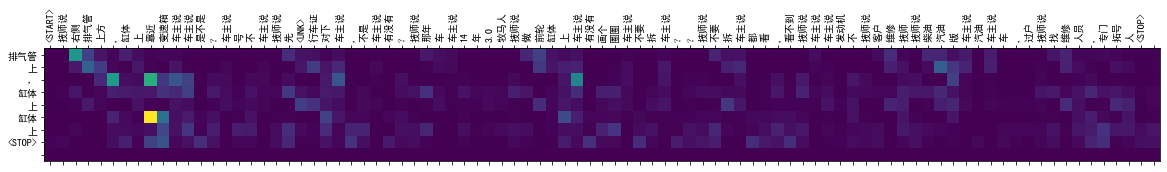

In [27]:
generate_summary(sentence, vocab, params)

# 批量预测

In [32]:
def batch_greedy_decode(model, batch_data, vocab, params):
    # 判断输入长度
    batch_size = len(batch_data)
    # 开辟结果存储list
    predicts = ['']*batch_size
    
    inps = tf.convert_to_tensor(batch_data)
    # 0. 初始化 encoder 隐藏层
    hidden = tf.zeros((batch_size, params['enc_units']))
    # 1. 构建encoder
    enc_output, enc_hidden = model.encoder(inps, hidden)
    # 2. 初始化 decoder 隐藏层
    dec_hidden = enc_hidden
    # 3. 初始化 decoder的输入 <START> * BATCH_SIZE
    dec_input = tf.expand_dims([vocab.START_DECODING_INDEX] * batch_size, 1)
    # 4. 基于注意力的context_vector
    context_vector, _ = model.attention(dec_hidden, enc_output)
    # 5. Teacher forcing - feeding the target as the next input
    for t in range(params['max_dec_len']):
        # 6. 单步预测
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        predictions, dec_hidden = model.decoder(dec_input,
                                               dec_hidden,
                                               enc_output,
                                               context_vector)
        # 7. id转换 贪婪搜索
        predicted_ids = tf.argmax(predictions, axis=1).numpy()
        for index, predicted_id in enumerate(predicted_ids):
            predicts[index] += vocab.id2word[predicted_id] + ' '
        # 8. using teacher forcing
        dec_input = tf.expand_dims(predicted_ids, 1)
        
    # 9. 预测结果整理
    results = []
    for predict in predicts:
        # 9.1 去掉句子前后空格
        predict = predict.strip()
        # 9.2 发现<STOP> 截断
        if vocab.STOP_DECODING in predict:
            predict = predict[:predict.index(vocab.STOP_DECODING)]
        results.append(predict)
    return results

In [33]:
from tqdm import tqdm
import math

In [34]:
def greedy_decode(model, data_X, batch_size, vocab, params):
    # 存储结果
    results = []
    # 样本数量
    sample_size = len(data_X)
    # batch 操作轮数 math.ceil向上取整 小数 +1
    # 因为最后一个batch可能不足一个batch size 大小 ,但是依然需要计算
    steps_epoch = math.ceil(sample_size / batch_size)
    # [0,steps_epoch)
    for i in tqdm(range(steps_epoch)):
        batch_data = data_X[i * batch_size:(i + 1) * batch_size]
        results += batch_greedy_decode(model, batch_data, vocab, params)
    return results

In [35]:
%%time
test_X = load_test_dataset(params["max_enc_len"])
results = greedy_decode(model, test_X, params['batch_size'], vocab, params)

100%|██████████| 625/625 [22:16<00:00,  2.14s/it]

CPU times: user 1h 28min 37s, sys: 24min 20s, total: 1h 52min 57s
Wall time: 22min 16s


In [36]:
len(test_X)/params['batch_size']

625.0

In [37]:
results[1005]

'车子 最低 配 汽车 大师 APP ， APP 内 搜索 名字 ， '

In [38]:
# 读入提交数据
test_df=pd.read_csv(test_data_path)
test_df.head()

,QID,Brand,Model,Question,Dialogue
0,Q1,大众(进口),高尔夫(进口),我的帕萨特烧机油怎么办怎么办？,技师说：你好，请问你的车跑了多少公里了，如果在保修期内，可以到当地的4店里面进行检查维修。如...
1,Q2,一汽-大众奥迪,奥迪A6,修一下多少钱是换还是修,技师说：你好师傅！抛光处理一下就好了！50元左右就好了，希望能够帮到你！祝你生活愉快！
2,Q3,上汽大众,帕萨特,帕萨特领域 喇叭坏了 店里说方向盘里线坏了 换一根两三百不等 感觉太贵,技师说：你好，气囊油丝坏了吗，这个价格不贵。可以更换。
3,Q4,南京菲亚特,派力奥,发动机漏气会有什么征兆？,技师说：你好！一：发动机没力，并伴有“啪啪”的漏气声音。二：发动机没力，并伴有排气管冒黑烟。...
4,Q5,东风本田,思铂睿,请问 那天右后胎扎了订，补了胎后跑高速80多开始有点抖，110时速以上抖动明显，以为是未做动...,技师说：你好师傅！可能前轮平衡快脱落或者不平衡造成的！建议前轮做一下动平衡就好了！希望能够帮...


# 判断是否有空值

In [39]:
for idx,result in enumerate(results):
    if result=='':print(idx)

9121
10574


In [40]:
# 赋值结果
test_df['Prediction']=results
#　提取ID和预测结果两列
test_df=test_df[['QID','Prediction']]

In [41]:
test_df.head()

,QID,Prediction
0,Q1,你好 ！ 车子 烧 机油 ， 建议 及时 维修 。
1,Q2,显示 ， 需要 进行 抛光 处理 ， 价位 800 左右 ！
2,Q3,气囊 问题 ， 更换 ， 价格 不 贵 ， 价格 不 贵 ， 价格 不 贵 ， 价格 不 贵...
3,Q4,分析 检查 排气管 漏气 。
4,Q5,你好 ！ 这种 情况 可能 轮胎 平衡 轴 位置 不 平衡 导致 ， 建议 做个 四轮 动平衡


# 结果处理

In [42]:
# 判断是否有空值
test_df.isnull().sum()

QID           0
Prediction    0
dtype: int64

In [43]:
test_df[test_df['Prediction']==''].index

Int64Index([9121, 10574], dtype='int64')

In [44]:
def submit_proc(sentence):
    sentence=sentence.lstrip(' ，！。') #lstrip截掉字符串左边的空格或指定字符
    sentence=sentence.replace(' ','')
    if sentence=='':
        sentence='随时联系'
    return sentence

In [45]:
test_df['Prediction']=test_df['Prediction'].apply(submit_proc)

In [46]:
test_df.iloc[9121,:]

QID           Q9122
Prediction     随时联系
Name: 9121, dtype: object

In [47]:
test_df.head()

,QID,Prediction
0,Q1,你好！车子烧机油，建议及时维修。
1,Q2,显示，需要进行抛光处理，价位800左右！
2,Q3,气囊问题，更换，价格不贵，价格不贵，价格不贵，价格不贵，价格不贵，价格不贵，价格不贵，价格不...
3,Q4,分析检查排气管漏气。
4,Q5,你好！这种情况可能轮胎平衡轴位置不平衡导致，建议做个四轮动平衡


# 保存结果

In [48]:
from utils.file_utils import get_result_filename

In [49]:
# 获取结果存储路径

result_save_path = get_result_filename(params["batch_size"],params["epochs"] , params["max_enc_len"], params["embedding_dim"],commit='_4_1_submit_greedy_search_seq2seq_code')


In [53]:
result_save_path

'/Users/ianxiao/Code/DeepLearning/class04/result/2020_07_13_17_46_49_batch_size_32_epochs_5_max_length_inp_200_embedding_dim_300_4_1_submit_greedy_search_seq2seq_code.csv'

In [54]:
# 保存结果.
test_df.to_csv(result_save_path,index=None,sep=',')

In [55]:
# 读取结果
test_df=pd.read_csv(result_save_path)
# 查看格式
test_df.head(10)

,QID,Prediction
0,Q1,你好！车子烧机油，建议及时维修。
1,Q2,显示，需要进行抛光处理，价位800左右！
2,Q3,气囊问题，更换，价格不贵，价格不贵，价格不贵，价格不贵，价格不贵，价格不贵，价格不贵，价格不...
3,Q4,分析检查排气管漏气。
4,Q5,你好！这种情况可能轮胎平衡轴位置不平衡导致，建议做个四轮动平衡
5,Q6,车子排气管热涨冷缩，车子排气管积水，排气管积水，排气管积水，排气管积水，排气管积水，排气管积...
6,Q7,你好！防冻液两年添加，添加相同颜色。
7,Q8,发动机机油灯亮，发动机故障灯亮，发动机动力下降，发动机动力下降，发动机动力下降，发动机动力下...
8,Q9,来看，轮胎鼓包，鼓包，轮胎花纹深度出现问题，轮胎鼓包，胎侧没有鼓包，轮胎鼓包，胎侧深度，鼓包...
9,Q10,这种情况主要天气太冷，时间长以后，没有问题，不用担心。


# ROUGE

# 角度1：QA 问题

# 角度2： 摘要问题

# 角度3： 阅读理解问题

> 如果看成是阅读理解问题， 那么就是从Conversation中找出能回答Problem的答案， 由于目前的阅读理解数据集的答案长度通常比较短（一般是几个单词），所以state of the art的作法是根据Problem，从Context中选择一段作为答案，模型只要输出答案的开始和结束位置即可。 但是这个任务的report有点长，常常出现几十个甚至上百个词， 而且report中的词好像并不完全是来自于Conversation。 Report中67.7%的词来自于Conversation.

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs
* [Neural Machine Translation (seq2seq) Tutorial](https://github.com/tensorflow/nmt)
